Veri seti Beyaz Saray ve önde gelen araştırma grupları tarafından oluşturulan Covid-19 açık kaynak veri setidir. CORD-19 veri seti, mevcut olan en kapsamlı koronavirüs literatür koleksiyonunu temsil ediyor. Koronavirüs literatüründeki hızlı değişimlere bilim insanlarının ayak uydurmaları zorluklara neden olmaktadır. Bu nedenle tıp camiasının yüksek öncelikli bilimsel sorulara yanıtlar geliştirmesine yardımcı olabilecek metin ve veri madenciliği araçları geliştirmesi amaçlanmaktadır.

In [27]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# **Veri İnceleme ve Ön İşleme**

Önce veriyi inceleyerek başlayalım.

In [28]:
input_path = "/kaggle/input/CORD-19-research-challenge/"
print("Veri seti dosyaları:")
for file in os.listdir(input_path):
    print(f"- {file}")

Veri seti dosyaları:
- Kaggle
- cord_19_embeddings
- document_parses
- COVID.DATA.LIC.AGMT.pdf
- metadata.readme
- json_schema.txt
- metadata.csv


In [29]:
metadata = pd.read_csv(input_path + "metadata.csv")
metadata.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [30]:
print(f"Toplam makale sayısı: {len(metadata)}")

Toplam makale sayısı: 1056660


Veri için basit bir arama sistemi oluşturacağız. O nedenle ilk önce arama yapacağımız kısımları analiz etmemiz gerekiyor.

In [31]:
print(metadata.columns.tolist())

['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id']


In [32]:
search_fields = ['title', 'abstract', 'authors', 'journal', 'publish_time']
print("\nArama alanları analizi:")
for field in search_fields:
    if field in metadata.columns:
        non_null = metadata[field].notna().sum()
        percentage = (non_null / len(metadata)) * 100
        print(f"{field}: {non_null}/{len(metadata)} (%{percentage:.1f})")


Arama alanları analizi:
title: 1056157/1056660 (%100.0)
abstract: 821116/1056660 (%77.7)
authors: 1032791/1056660 (%97.7)
journal: 969338/1056660 (%91.7)
publish_time: 1054846/1056660 (%99.8)


Buradan şunu anlıyoruz; her makalenin adı var nerdeyse hepsinin yazarı ve yayın tarihi mevcut. Yani başlık, yazar ve yayın tarihi aramaları çok iyi sonuçlar verebilir. Bazı makalelerin dergi bilgisi yok, biraz daha fazla makalenin de özeti yok. Özet sistemi daha sonra dahil edilebilir.

In [33]:
# Başlık analizi
titles_with_text = metadata['title'].notna()
print(f"Başlığı olan makale sayısı: {titles_with_text.sum()}")

if titles_with_text.sum() > 0:
    # Başlık uzunluklarını kontrol
    title_lengths = metadata[titles_with_text]['title'].str.len()
    print(f"Ortalama başlık uzunluğu: {title_lengths.mean():.1f} karakter")
    print(f"En kısa başlık: {title_lengths.min()}")
    print(f"En uzun başlık: {title_lengths.max()}")

# Özet analizi
abstracts_with_text = metadata['abstract'].notna()
print(f"\nÖzeti olan makale sayısı: {abstracts_with_text.sum()}")

if abstracts_with_text.sum() > 0:
    abstract_lengths = metadata[abstracts_with_text]['abstract'].str.len()
    print(f"Ortalama özet uzunluğu: {abstract_lengths.mean():.1f} karakter")

Başlığı olan makale sayısı: 1056157
Ortalama başlık uzunluğu: 99.1 karakter
En kısa başlık: 2
En uzun başlık: 1504

Özeti olan makale sayısı: 821116
Ortalama özet uzunluğu: 1461.5 karakter


In [34]:
# Hem başlık hem özet olan makaleler
both_available = metadata['title'].notna() & metadata['abstract'].notna()
print(f"Hem başlık hem özet olan makale: {both_available.sum()}")

# Sadece başlık olan makaleler
only_title = metadata['title'].notna() & metadata['abstract'].isna()
print(f"Sadece başlık olan makale: {only_title.sum()}")

# Tam metin JSON dosyası olan makaleler
has_pdf_json = metadata['pdf_json_files'].notna() & (metadata['pdf_json_files'] != '')
has_pmc_json = metadata['pmc_json_files'].notna() & (metadata['pmc_json_files'] != '')
has_fulltext = has_pdf_json | has_pmc_json

print(f"PDF JSON dosyası olan makale: {has_pdf_json.sum()}")
print(f"PMC JSON dosyası olan makale: {has_pmc_json.sum()}")
print(f"Herhangi bir tam metin dosyası olan makale: {has_fulltext.sum()}")

# Arama kalitesi analizi
print(f"🥇 Altın seviye (başlık + özet + tam metin): {(both_available & has_fulltext).sum()}")
print(f"🥈 Gümüş seviye (başlık + özet): {(both_available & ~has_fulltext).sum()}")
print(f"🥉 Bronz seviye (sadece başlık): {only_title.sum()}")

Hem başlık hem özet olan makale: 821005
Sadece başlık olan makale: 235152
PDF JSON dosyası olan makale: 373766
PMC JSON dosyası olan makale: 315742
Herhangi bir tam metin dosyası olan makale: 389899
🥇 Altın seviye (başlık + özet + tam metin): 334585
🥈 Gümüş seviye (başlık + özet): 486420
🥉 Bronz seviye (sadece başlık): 235152


Şimdi arama sistemimizi daha iyi uyarlamak için birkaç örnek veriye bakalım.

In [35]:
sample_data = metadata[both_available].head(3)

for i, row in sample_data.iterrows():
    print(f"\n--- Makale {i+1} ---")
    print(f"Başlık: {row['title'][:100]}...")
    print(f"Özet: {row['abstract'][:150]}...")
    print(f"Dergi: {row['journal']}")
    print(f"Tarih: {row['publish_time']}")


--- Makale 1 ---
Başlık: Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Ho...
Özet: OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae i...
Dergi: BMC Infect Dis
Tarih: 2001-07-04

--- Makale 2 ---
Başlık: Nitric oxide: a pro-inflammatory mediator in lung disease?...
Özet: Inflammatory diseases of the respiratory tract are commonly associated with elevated production of nitric oxide (NO•) and increased indices of NO• -de...
Dergi: Respir Res
Tarih: 2000-08-15

--- Makale 3 ---
Başlık: Surfactant protein-D and pulmonary host defense...
Özet: Surfactant protein-D (SP-D) participates in the innate response to inhaled microorganisms and organic antigens, and contributes to immune and inflamma...
Dergi: Respir Res
Tarih: 2000-08-25


In [37]:
import re
import string
from collections import Counter
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# Stop words ve lemmatizer hazırlama
stop_words = set(stopwords.words('english'))
medical_stop_words = {
    'study', 'analysis', 'research', 'paper', 'article', 'method', 'result', 
    'conclusion', 'background', 'objective', 'patient', 'clinical', 'data',
    'significant', 'observed', 'reported', 'showed', 'found', 'using', 'used'
}
stop_words.update(medical_stop_words)
lemmatizer = WordNetLemmatizer()

# Metin temizleme fonksiyonu
def clean_text(text):
    if pd.isna(text) or text == '':
        return ''
    text = str(text)
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)  # HTML tagları
    text = re.sub(r'http\S+|www\S+', '', text)  # URL'ler
    text = re.sub(r'\d+', '', text)  # Sayılar
    text = re.sub(r'[^\w\s]', ' ', text)  # Noktalama işaretleri
    text = ' '.join(text.split())
    return text

# Tam ön işleme fonksiyonu
def preprocess_text(text):
    text = clean_text(text)
    if not text:
        return ''
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    return ' '.join(tokens)

# Test edelim
print("=== FONKSİYON TESTLERİ ===")
test1 = "COVID-19 symptoms in children (n=150) were analyzed. Visit: https://example.com"
print("Test 1 - Original:", test1)
print("Test 1 - Cleaned:", clean_text(test1))

test2 = "This study analyzed COVID-19 symptoms in pediatric patients using clinical data."
print("\nTest 2 - Original:", test2)
print("Test 2 - Preprocessed:", preprocess_text(test2))

=== FONKSİYON TESTLERİ ===
Test 1 - Original: COVID-19 symptoms in children (n=150) were analyzed. Visit: https://example.com
Test 1 - Cleaned: covid symptoms in children n were analyzed visit

Test 2 - Original: This study analyzed COVID-19 symptoms in pediatric patients using clinical data.
Test 2 - Preprocessed: analyzed covid symptom pediatric patient


In [38]:
# Arama için kullanacağımız makaleleri seçelim
search_ready_papers = metadata[
    metadata['title'].notna() & 
    metadata['abstract'].notna()
].copy()

print(f"İşlenecek makale sayısı: {len(search_ready_papers)}")

# Başlık ve özet ön işleme 
sample_size = 1000  # Hızlı test için 1000 olarak ayarladım, sonra artırabilirim
sample_papers = search_ready_papers.head(sample_size).copy()

print(f"Örnek işleme: {len(sample_papers)} makale")

# Ön işleme uygulama
sample_papers['processed_title'] = sample_papers['title'].apply(preprocess_text)
sample_papers['processed_abstract'] = sample_papers['abstract'].apply(preprocess_text)

# Başlık + özet birleştirme (arama için)
sample_papers['search_text'] = (
    sample_papers['processed_title'] + ' ' + 
    sample_papers['processed_abstract']
)

İşlenecek makale sayısı: 821005
Örnek işleme: 1000 makale


In [39]:
# İşleme sonuçlarını kontrol edelim
print(f"İşlenen makale sayısı: {len(sample_papers)}")

# Örnek sonuçlar
idx = 0
print(f"Orijinal Başlık: {sample_papers.iloc[idx]['title']}")
print(f"İşlenmiş Başlık: {sample_papers.iloc[idx]['processed_title']}")
print(f"İşlenmiş Özet: {sample_papers.iloc[idx]['processed_abstract'][:200]}...")
print(f"Arama Metni: {sample_papers.iloc[idx]['search_text'][:300]}...")

İşlenen makale sayısı: 1000
Orijinal Başlık: Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia
İşlenmiş Başlık: feature culture proven mycoplasma pneumoniae infection king abdulaziz university hospital jeddah saudi arabia
İşlenmiş Özet: retrospective chart review describes epidemiology feature patient culture proven mycoplasma pneumoniae infection king abdulaziz university hospital jeddah saudi arabia method patient positive pneumoni...
Arama Metni: feature culture proven mycoplasma pneumoniae infection king abdulaziz university hospital jeddah saudi arabia retrospective chart review describes epidemiology feature patient culture proven mycoplasma pneumoniae infection king abdulaziz university hospital jeddah saudi arabia method patient positiv...


**Şimdi vektörizasyon için TF-IDF Modeli Oluşturacağım**

In [40]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,  # En önemli 5000 kelime
    min_df=2,          # En az 2 dokümanda geçmeli
    max_df=0.8,        # Dokümanların %80'inden fazlasında geçmesin
    ngram_range=(1, 2) # Tekli ve ikili kelime grupları
)

# Arama metinlerini vektörleştirme
search_texts = sample_papers['search_text'].fillna('')
tfidf_matrix = tfidf.fit_transform(search_texts)

print(f"TF-IDF matrisi oluşturuldu: {tfidf_matrix.shape}")
print(f"Kelime sayısı: {len(tfidf.get_feature_names_out())}")

# En önemli kelimeleri görelim
feature_names = tfidf.get_feature_names_out()
print(f"\nÖrnek kelimeler: {feature_names[:20]}")

TF-IDF matrisi oluşturuldu: (1000, 5000)
Kelime sayısı: 5000

Örnek kelimeler: ['aav' 'ab' 'aberrant' 'ability' 'able' 'abnormal' 'abnormality'
 'abolished' 'aboriginal' 'abortion' 'absence' 'absent' 'absolute'
 'abundance' 'abundant' 'abuse' 'academic' 'accept' 'accepted' 'access']


**Artık basit arama sistemini oluşturma kısmına geçebilirim.**

# **Arama Sistemi**

In [41]:
def search_papers(query, top_k=10):
    print(f"'{query}'")
    
    # Sorguyu aynı şekilde ön işleme
    processed_query = preprocess_text(query)
    print(f"İşlenmiş sorgu: '{processed_query}'")
    
    if not processed_query.strip():
        print("Geçersiz sorgu!")
        return []
    
    # Sorguyu vektörleştirme
    query_vector = tfidf.transform([processed_query])
    
    # Cosine similarity hesaplama
    similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    
    # En benzer makaleleri bulma
    top_indices = similarities.argsort()[-top_k:][::-1]
    
    # Sonuçları hazırlama
    results = []
    for i, idx in enumerate(top_indices):
        if similarities[idx] > 0:  # Sıfır benzerlik olanları atlama
            paper = sample_papers.iloc[idx]
            results.append({
                'rank': i + 1,
                'title': paper['title'],
                'abstract': paper['abstract'][:300] + '...',
                'journal': paper['journal'],
                'publish_time': paper['publish_time'],
                'similarity_score': round(similarities[idx], 4)
            })
    
    return results

def display_search_results(results):

    if not results:
        print("❌ Sonuç bulunamadı!")
        return
    
    print(f"\n📚 {len(results)} sonuç bulundu:")
    print("=" * 80)
    
    for result in results:
        print(f"\n{result['rank']}. 📄 {result['title']}")
        print(f"   📊 Benzerlik Skoru: {result['similarity_score']}")
        print(f"   📅 Tarih: {result['publish_time']}")
        print(f"   📖 Dergi: {result['journal']}")
        print(f"   📝 Özet: {result['abstract']}")
        print("-" * 80)

# Test edelim
print("ARAMA SİSTEMİ TESTİ")

# Test sorguları
test_queries = [
    "COVID-19 symptoms children",
    "pneumonia treatment",
    "respiratory infection"
]

for query in test_queries:
    print(f"\n🔍 TEST: {query}")
    results = search_papers(query, top_k=3)
    display_search_results(results)
    print("\n" + "="*100 + "\n")

ARAMA SİSTEMİ TESTİ

🔍 TEST: COVID-19 symptoms children
'COVID-19 symptoms children'
İşlenmiş sorgu: 'covid symptom child'

📚 3 sonuç bulundu:

1. 📄 Development of a Symptom Score for Clinical Studies to Identify Children With a Documented Viral Upper Respiratory Tract Infection
   📊 Benzerlik Skoru: 0.6325
   📅 Tarih: 2010
   📖 Dergi: Pediatr Res
   📝 Özet: The objective of this study was to develop a symptom scoring system for use in clinical studies that differentiates children with cold symptoms who have an identifiable viral etiology for their upper respiratory tract infection (URI) from those in whom no virus is detected. Nasal swabs for PCR testi...
--------------------------------------------------------------------------------

2. 📄 Serious Invasive Saffold Virus Infections in Children, 2009
   📊 Benzerlik Skoru: 0.3312
   📅 Tarih: 2012-01-03
   📖 Dergi: Emerg Infect Dis
   📝 Özet: The first human virus in the genus Cardiovirus was described in 2007 and named Saffold virus (SA

# **Görselleştirme**

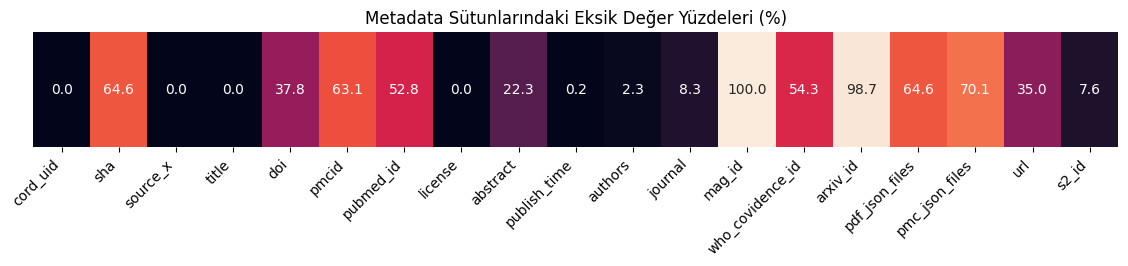

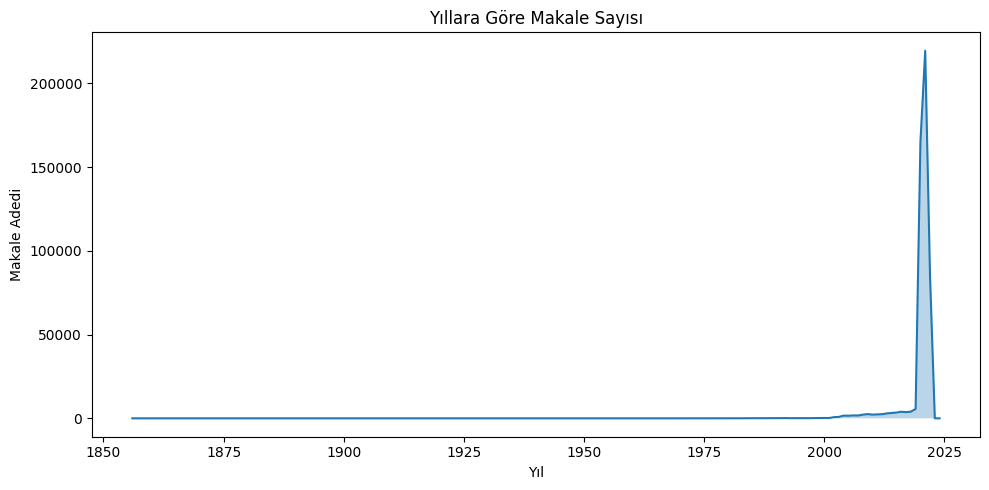

In [42]:
# Eksik Değer Heatmap
missing_percent = metadata.isnull().mean() * 100
plt.figure(figsize=(14, 1.5))
sns.heatmap(
    [missing_percent],
    annot=True,
    fmt=".1f",
    cbar=False,
    xticklabels=missing_percent.index,
    yticklabels=[]
)
plt.xticks(rotation=45, ha='right')
plt.title('Metadata Sütunlarındaki Eksik Değer Yüzdeleri (%)')
plt.tight_layout()
plt.show()

# 3. Yıllık Yayın Zaman Serisi
metadata['publish_time'] = pd.to_datetime(metadata['publish_time'], errors='coerce')
metadata['year'] = metadata['publish_time'].dt.year
yearly_counts = metadata['year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values)
plt.fill_between(yearly_counts.index, yearly_counts.values, alpha=0.3)
plt.title('Yıllara Göre Makale Sayısı')
plt.xlabel('Yıl')
plt.ylabel('Makale Adedi')
plt.tight_layout()
plt.show()

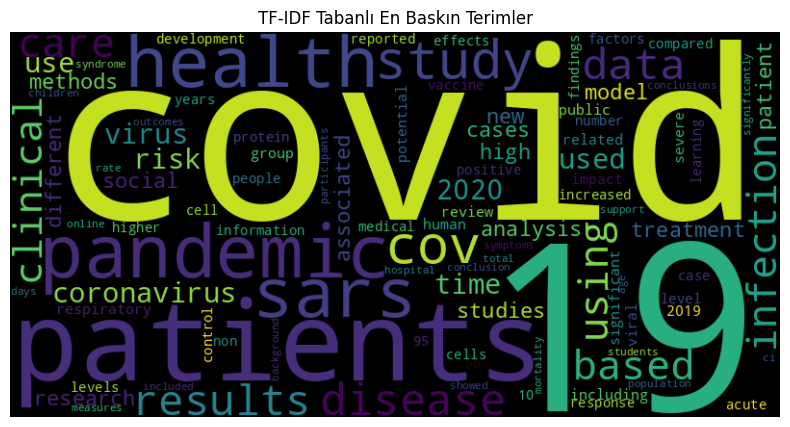

In [43]:
# TF‑IDF Word Cloud
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# tüm özetler üzerinde TF-IDF
docs = metadata['abstract'].dropna().values
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(docs)
scores = dict(zip(vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))

wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(scores)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Tabanlı En Baskın Terimler')
plt.show()


In [44]:
# Hangi sütunlar daha güvenilir?
reliable_columns = missing_percent[missing_percent < 10].index.tolist()
unreliable_columns = missing_percent[missing_percent > 50].index.tolist()

print(f"Güvenilir sütunlar: {reliable_columns}")
print(f"Problemli sütunlar: {unreliable_columns}")

Güvenilir sütunlar: ['cord_uid', 'source_x', 'title', 'license', 'publish_time', 'authors', 'journal', 's2_id']
Problemli sütunlar: ['sha', 'pmcid', 'pubmed_id', 'mag_id', 'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files']


Toplam COVID-19 makalesi: 518725
Yüksek kaliteli COVID-19 makalesi: 518570
Ortalama kalite skoru: 0.911


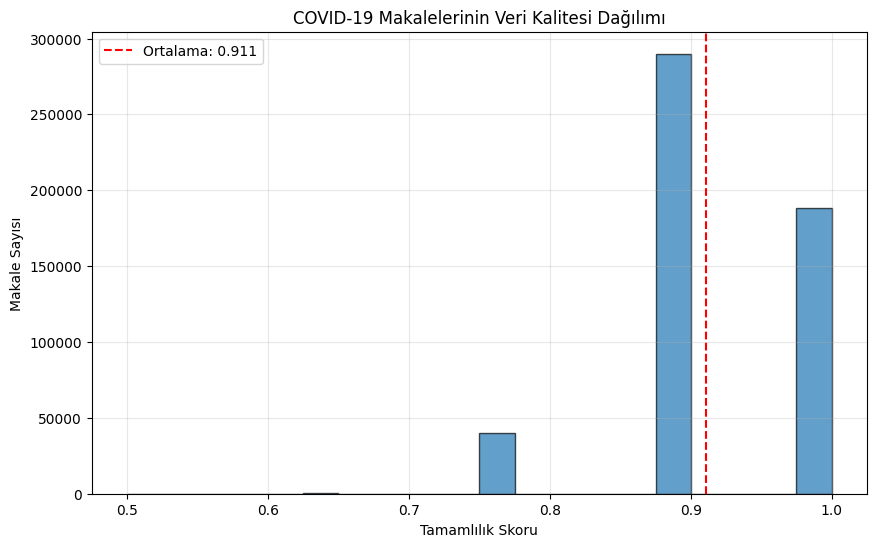

In [45]:
# Hangi COVID-19 makaleleri daha güvenilir?
covid_papers = metadata[metadata['abstract'].str.contains('covid|coronavirus', case=False, na=False)]

# Tamamlılık skoru hesaplama fonksiyonu
def calculate_completeness_score(df):
    """Her makale için tamamlılık skoru hesapla (0-1 arası)"""
    # Güvenilir sütunları kullan
    reliable_cols = ['cord_uid', 'source_x', 'title', 'license', 'publish_time', 'authors', 'journal', 's2_id']
    
    scores = []
    for idx, row in df.iterrows():
        # Bu makalede kaç güvenilir alan dolu?
        filled_count = sum(1 for col in reliable_cols if pd.notna(row[col]) and row[col] != '')
        completeness = filled_count / len(reliable_cols)
        scores.append(completeness)
    
    return pd.Series(scores, index=df.index)

# COVID-19 makaleleri için kalite skoru hesapla
covid_quality_score = calculate_completeness_score(covid_papers)

# Kaliteli COVID-19 makalelerini öne çıkar
high_quality_covid = covid_papers[covid_quality_score > 0.7]

print(f"Toplam COVID-19 makalesi: {len(covid_papers)}")
print(f"Yüksek kaliteli COVID-19 makalesi: {len(high_quality_covid)}")
print(f"Ortalama kalite skoru: {covid_quality_score.mean():.3f}")

# Kalite skorlarının dağılımı
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(covid_quality_score, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Tamamlılık Skoru')
plt.ylabel('Makale Sayısı')
plt.title('COVID-19 Makalelerinin Veri Kalitesi Dağılımı')
plt.axvline(covid_quality_score.mean(), color='red', linestyle='--', label=f'Ortalama: {covid_quality_score.mean():.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

COVID-19 ile ilgili makale sayısı: 540100


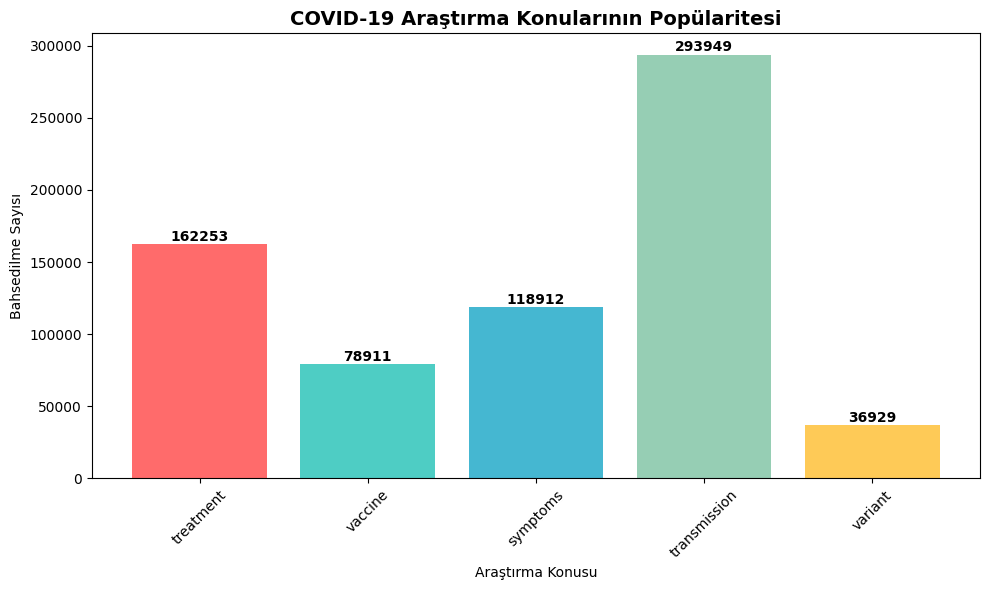

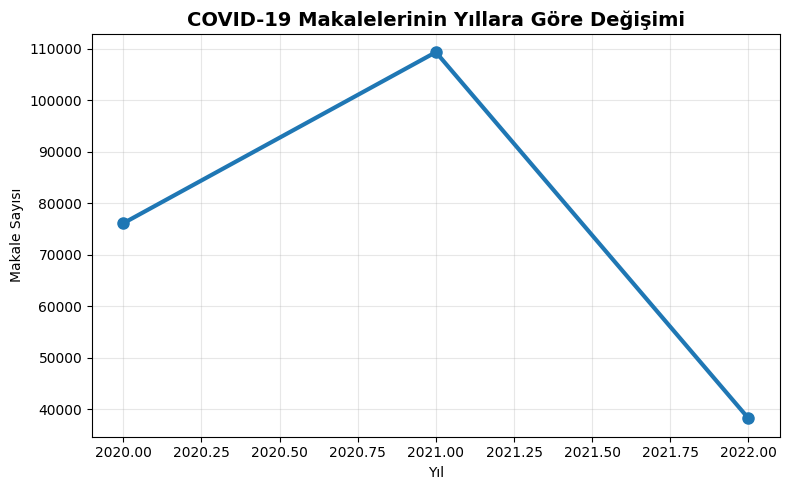


=== COVID-19 Araştırma Trend Özeti ===
Toplam COVID-19 makalesi: 540,100
En popüler konu: transmission
En az araştırılan konu: variant
Ortalama konu başına bahsedilme: 138191


In [46]:
# COVID-19 Basit Trend Analizi

covid_terms = {
    'treatment': ['treatment', 'therapy', 'drug'],
    'vaccine': ['vaccine', 'vaccination'],
    'symptoms': ['symptom', 'fever', 'cough'],
    'transmission': ['transmission', 'spread', 'infection'],
    'variant': ['variant', 'mutation', 'delta', 'omicron']
}

# 1. Terim Analizi
def analyze_covid_terms(df, terms_dict):
    """COVID-19 terimlerinin frekansını hesapla"""
    results = {}
    
    for category, terms in terms_dict.items():
        total_count = 0
        
        for term in terms:
            # Abstract'larda terim arama
            count = df['abstract'].str.contains(term, case=False, na=False).sum()
            total_count += count
        
        results[category] = total_count
    
    return results

# 2. COVID-19 Makalelerini Filtrele
covid_papers = metadata[metadata['abstract'].str.contains('covid|coronavirus|sars-cov-2', case=False, na=False)]
print(f"COVID-19 ile ilgili makale sayısı: {len(covid_papers)}")


term_counts = analyze_covid_terms(covid_papers, covid_terms)

# 3. Basit Görselleştirme
categories = list(term_counts.keys())
counts = list(term_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'])
plt.title('COVID-19 Araştırma Konularının Popülaritesi', fontsize=14, fontweight='bold')
plt.xlabel('Araştırma Konusu')
plt.ylabel('Bahsedilme Sayısı')
plt.xticks(rotation=45)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. Yıllara Göre COVID-19 Makale Sayısı
covid_papers_copy = covid_papers.copy()
covid_papers_copy['publish_time'] = pd.to_datetime(covid_papers_copy['publish_time'], errors='coerce')
covid_papers_copy['year'] = covid_papers_copy['publish_time'].dt.year

# 2020-2023 arası
covid_by_year = covid_papers_copy[covid_papers_copy['year'].between(2020, 2023)]['year'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.plot(covid_by_year.index, covid_by_year.values, marker='o', linewidth=3, markersize=8)
plt.title('COVID-19 Makalelerinin Yıllara Göre Değişimi', fontsize=14, fontweight='bold')
plt.xlabel('Yıl')
plt.ylabel('Makale Sayısı')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Özet
print("\n=== COVID-19 Araştırma Trend Özeti ===")
print(f"Toplam COVID-19 makalesi: {len(covid_papers):,}")
print(f"En popüler konu: {max(term_counts, key=term_counts.get)}")
print(f"En az araştırılan konu: {min(term_counts, key=term_counts.get)}")
print(f"Ortalama konu başına bahsedilme: {np.mean(list(term_counts.values())):.0f}")